In [1]:
import sys
# sys.path.append("/home/diego/python/spike-train/") 
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")
sys.path.append("/home/diego/python/utils/") 
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim import Adam
# import pickle

from gglm.utils import shift_array
from sptr.sptr import SpikeTrain
# from gglm.glm.base import GLM
from gglm.glm.torchglm import TorchGLM
from gglm.lif import LIF
from kernel.fun import KernelFun
from kernel.rect import KernelRect
from processes.ou import OUProcess
from processes.multivariate_ou import MultivariateOUProcess
# from icglm.kernels.rect import KernelRect

%load_ext autoreload
%autoreload 2
plt.close('all')

### lif

22.233333333333334
 epoch 2499 of 2500 nll 1734.7126n_spikes 20.96


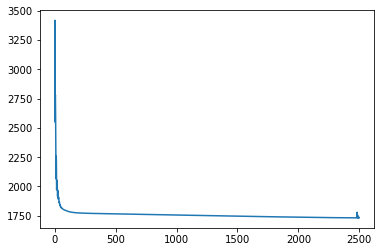

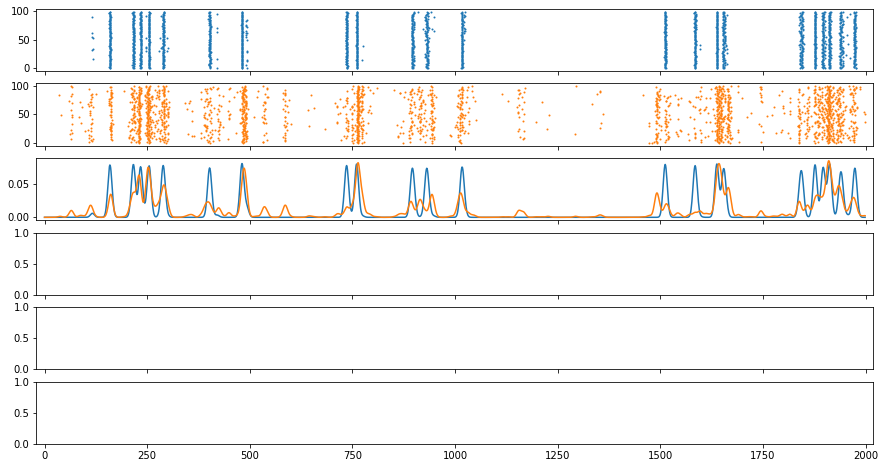

In [8]:
# np.random.seed(0)

dt = 1
t = np.arange(0, 2000, 1)
lif = LIF(tau=50, R=1e0, vr=-65, vt=-54, vrst=-60, tref=4)

r = 1
n = 120
n_train = 20

mu, sd, sigma = 7.5, 15, 0.5
stim = OUProcess(mu=mu, sd=sd, tau=10).sample(t, shape=(1,))
stim = np.stack([stim[:, 0]] * n, 1)
stim_train = stim[:, :n_train]
stim_val = stim[:, n_train:]

v, mask_spikes_d = lif.sample(-65, t, stim, sigma=sigma)
mask_spikes_d_train = mask_spikes_d[:, :n_train]
mask_spikes_d_val = mask_spikes_d[:, n_train:]

st_d = SpikeTrain(t, mask_spikes_d)
st_train = SpikeTrain(t, mask_spikes_d_train)
st_val = SpikeTrain(t, mask_spikes_d_val)
ker_gauss = KernelFun.gaussian_delta(5)

print(np.mean(np.sum(mask_spikes_d, 0)))

# tbins_kappa = np.array([0, 1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 28, 32, 48, 64, 96, 128, 192, 256])
# tbins_kappa = np.array([0, 2, 4, 8, 12, 16, 24, 28, 32, 48, 64, 96, 160])
tbins_kappa = np.array([0, 2, 4, 8, 16, 24, 32, 48, 64, 96, 160])
# tbins_eta = np.arange(0, 60, 2)
# tbins_eta = np.array([0, 4, 8, 12, 16, 24, 32])
tbins_eta = np.array([0, 4, 8])

# glm_fit = GLM(u0=-10, kappa=KernelRect(tbins_kappa, coefs=np.zeros(len(tbins_kappa) - 1) + 2e-3), 
#               eta=KernelRect(tbins_eta, coefs=np.zeros(len(tbins_eta) - 1) - 20))
# opt = glm_fit.fit(t, mask_spikes_d_train, stim=stim[:, :n // 2], verbose=True, newton_kwargs=dict(learning_rate=1e-1, 
#                                                                            stop_cond=1e-12, max_iterations=300))

glm_fit = TorchGLM(u0=-10, kappa=KernelRect(tbins_kappa, coefs=np.zeros(len(tbins_kappa) - 1) + 2e-3), 
                   eta=KernelRect(tbins_eta, coefs=np.zeros(len(tbins_eta) - 1) - 20), noise='bernoulli')
optim = Adam(glm_fit.parameters(), lr=1e-3, betas=(0.9, 0.999))
# optim = Adam([{'params': mmdglm.b, 'lr': 1e-4}, {'params': mmdglm.kappa_coefs}], lr=lr, betas=(0.9, 0.999))
nll, metrics_list = glm_fit.train(t, mask_spikes_d_train, stim=stim_train, optim=optim, num_epochs=2500, 
                                   verbose=True, metrics=None)

fig, ax = plt.subplots()
ax.plot(nll)

u_fr, r_fr, mask_spikes_fr = glm_fit.sample(t, stim=stim_val)
u_dc, r_dc = glm_fit.sample_conditioned(t, mask_spikes_d_train, stim=stim_train)
st_fr = SpikeTrain(t, mask_spikes_fr)

psth_d = np.mean(st_d.convolve(ker_gauss), 1)
psth_fr = np.mean(st_fr.convolve(ker_gauss), 1)

print('n_spikes', np.mean(np.sum(mask_spikes_fr, 0)))

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(15, 8), nrows=6, sharex=True)
st_val.plot(ax=ax1, ms=1)
st_fr.plot(ax=ax2, ms=1, color='C1')
ax3.plot(t, psth_d)
ax3.plot(t, psth_fr)

np.savez('reliability', glm_u0=glm_fit.u0, glm_tbins_kappa=glm_fit.kappa.tbins, glm_coefs_kappa=glm_fit.kappa.coefs, 
         glm_tbins_eta=glm_fit.eta.tbins, glm_coefs_eta=glm_fit.eta.coefs, t=t, mask_spikes_d=mask_spikes_d, stim=stim, 
         mask_spikes_fr=mask_spikes_fr, u_dc=u_dc, u_fr=u_fr, r_dc=r_dc, r_fr=r_fr, log_likelihood=nll)

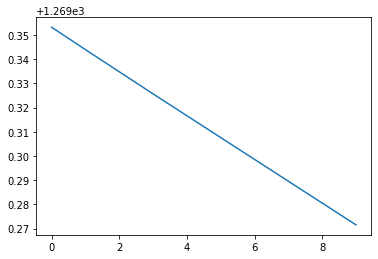

In [34]:
plt.plot(nll[-10:])

-8.033251662831313


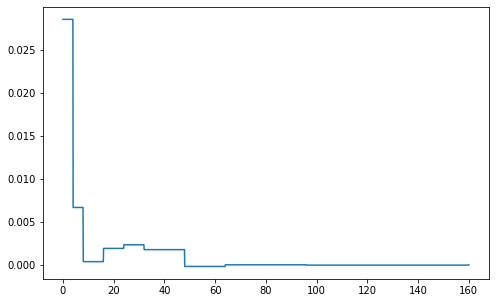

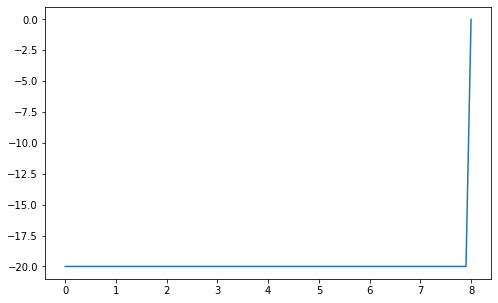

In [4]:
print(glm_fit.u0)
glm_fit.kappa.plot()
glm_fit.eta.plot()

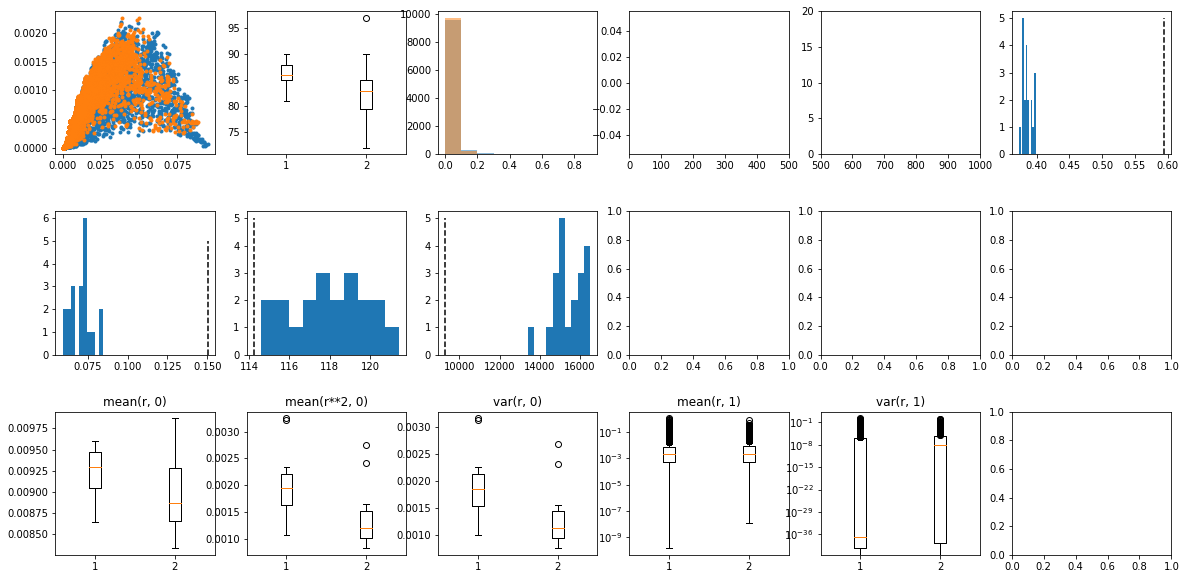

In [20]:
ker = KernelFun.gaussian_delta(4)

rel_te = st_te.reliability(ker, ker)
fano_te = np.mean(st_te.sliding_fano_factor(ker))
rels, fanos = [], []
mean_isis, var_isis = [], []
for ii in range(20):
    _u_fr, _r_fr, _mask_spikes_fr = glm_fit.sample(t, stim=stim)
    _st = SpikeTrain(t, _mask_spikes_fr)
    rels.append(_st.reliability(ker, ker))
    fanos.append(np.mean(_st.sliding_fano_factor(ker)))
    _isi_fr = _st.isi_distribution()
    mean_isis.append(np.mean(_isi_fr))
    var_isis.append(np.var(_isi_fr))

mean_spk_te = st_te.convolve(ker)
mean_spk_fr = st_fr.convolve(ker)
var_spk_te = np.var(mean_spk_te, 1)
var_spk_fr = np.var(mean_spk_fr, 1)
mean_spk_te = np.mean(mean_spk_te, 1)
mean_spk_fr = np.mean(mean_spk_fr, 1)

bins = np.arange(0, 1050, 50)
isi_te = st_te.isi_distribution()
mean_isi_te, var_isi_te = np.mean(isi_te), np.var(isi_te)
isi_fr = st_fr.isi_distribution()

fig, ((ax1, ax2, ax3, ax4, ax5, ax6), (ax7, ax8, ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16, ax17, ax18)) = plt.subplots(figsize=(20, 10), nrows=3, ncols=6)
fig.subplots_adjust(hspace=0.4)
ax1.plot(mean_spk_te, var_spk_te, '.')
ax1.plot(mean_spk_fr, var_spk_fr, '.')

m1, m2 = np.sum(mask_spikes_te, 0), np.sum(mask_spikes_fr, 0)
ax2.boxplot(x=(m1, m2));
m1, m2 = np.mean(mask_spikes_te, 1), np.mean(mask_spikes_fr, 1)
bins = np.arange(0, 1, .1)
ax3.hist(m1, alpha=0.5, bins=bins);
ax3.hist(m2, alpha=0.5, bins=bins);

ax4.hist(isi_te, bins=bins, alpha=0.5);
ax4.hist(isi_fr, bins=bins, alpha=0.5);
ax4.set_xlim(0, 500)
ax5.hist(isi_te, bins=bins, alpha=0.5);
ax5.hist(isi_fr, bins=bins, alpha=0.5);
ax5.set_xlim(500, 1000)
ax5.set_ylim(0, 20)

ax6.hist(rels)
ax6.plot([rel_te, rel_te], [0, 5], 'k--')
ax7.hist(fanos)
ax7.plot([fano_te, fano_te], [0, 5], 'k--')

ax8.hist(mean_isis)
ax8.plot([mean_isi_te, mean_isi_te], [0, 5], 'k--')
ax9.hist(var_isis)
ax9.plot([var_isi_te, var_isi_te], [0, 5], 'k--')

r1, r2 = np.mean(r_te, 0), np.mean(r_fr, 0)
ax13.boxplot(x=(r1, r2))
ax13.set_title('mean(r, 0)')

r1, r2 = np.mean(r_te**2, 0), np.mean(r_fr**2, 0)
ax14.boxplot(x=(r1, r2))
ax14.set_title('mean(r**2, 0)')

r1, r2 = np.var(r_te, 0), np.var(r_fr, 0)
ax15.boxplot(x=(r1, r2))
ax15.set_title('var(r, 0)')
# ax14.set_yscale('log')

r1, r2 = np.mean(r_te, 1), np.mean(r_fr, 1)
ax16.boxplot(x=(r1, r2))
ax16.set_title('mean(r, 1)')
ax16.set_yscale('log')

r1, r2 = np.var(r_te, 1), np.var(r_fr, 1)
ax17.boxplot(x=(r1, r2))
ax17.set_title('var(r, 1)')
ax17.set_yscale('log')